# 스타벅스 이디야 원데이 with SQL

이디야커피는 스타벅스 커피 매장이 위치하는 곳에 매장을 위치시키는 것인가? >> 검증

In [1]:
""" For EDA ======================================= """
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains

from bs4 import BeautifulSoup

import re

import json
from glob import glob

import time
from tqdm.notebook import tqdm

import folium

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
import plotly.express as px

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

""" For SQL ======================================= """
import mysql.connector


## 1. 서울시의 스타벅스 매장 정보를 데이터베이스에 저장

### flow check

In [140]:
url = "https://www.starbucks.co.kr/index.do"

driver = webdriver.Chrome(service=Service("../EDA/driver/chromedriver"))
driver.get(url)

driver.maximize_window()
driver.implicitly_wait(3)

if driver is not None:
    print("웹페이지 접속 완료", "\n")

웹페이지 접속 완료 



- ```store``` 메뉴 > ```매장 찾기```의 ```지역 검색``` 옵션 클릭

In [141]:
store_menu = driver.find_element(By.CLASS_NAME, "gnb_nav03")
loca_search_option = driver.find_element(By.CSS_SELECTOR, "#gnb > div > nav > div > ul > li.gnb_nav03 > div > div > div > ul:nth-child(1) > li:nth-child(3) > a")

action = ActionChains(driver)
action.move_to_element(store_menu)
action.move_to_element(loca_search_option)
action.click().perform()

- ```시도``` 옵션 리스트 생성

In [142]:
wait = WebDriverWait(driver, 5)
sido_box = wait.until(EC.presence_of_element_located((By.CLASS_NAME, "sido_arae_box")))
sido_list = sido_box.find_elements(By.TAG_NAME, "li")

for idx, sido_item in enumerate(sido_list):
    print("%4s"%(str(idx)), sido_item.find_element(By.TAG_NAME, "a").text)

   0 서울
   1 경기
   2 광주
   3 대구
   4 대전
   5 부산
   6 울산
   7 인천
   8 강원
   9 경남
  10 경북
  11 전남
  12 전북
  13 충남
  14 충북
  15 제주
  16 세종


- ```서울``` 클릭

In [143]:
wait = WebDriverWait(sido_list[0], 5)
seoul_option = wait.until(EC.element_to_be_clickable((By.TAG_NAME, "a")))
seoul_option.click()

- ```구``` 옵션 리스트 생성

In [144]:
wait = WebDriverWait(driver, 5)
gu_box = wait.until(EC.presence_of_element_located((By.CLASS_NAME, "gugun_arae_box")))
gu_list = gu_box.find_elements(By.TAG_NAME, "li")

for idx, gu_item in enumerate(gu_list):
    print("%4s"%(str(idx)), gu_item.find_element(By.TAG_NAME, "a").get_attribute("innerHTML"))

   0 전체
   1 강남구
   2 강동구
   3 강북구
   4 강서구
   5 관악구
   6 광진구
   7 구로구
   8 금천구
   9 노원구
  10 도봉구
  11 동대문구
  12 동작구
  13 마포구
  14 서대문구
  15 서초구
  16 성동구
  17 성북구
  18 송파구
  19 양천구
  20 영등포구
  21 용산구
  22 은평구
  23 종로구
  24 중구
  25 중랑구


- ```전체``` 클릭

In [145]:
wait = WebDriverWait(gu_list[0], 5)
total_gu_option = wait.until(EC.element_to_be_clickable((By.TAG_NAME, "a")))
total_gu_option.click()

- ```매장 정보``` 추출

Selenium으로 서울시 전체 스타벅스 매장 검색 결과 출력 작업 수행 완료 후, 해당 페이지의 html 소스를 가져옴.  
BeautifulSoup으로 html 파싱을 통해 원하는 정보를 추출.

In [146]:
# 검색 결과가 모두 로딩될 때까지 기다림.
wait = WebDriverWait(driver, 5)
wait.until(EC.presence_of_element_located((By.CLASS_NAME, "quickResultLstCon")))

# 필요한 selenium 작업이 수행된 후, 해당 접속 사이트 url 정보를 가져옴
html = driver.page_source

driver.close()

# html parsing 함
soup = BeautifulSoup(html, "html.parser")

store_list = soup.find_all("li", "quickResultLstCon")
print(store_list[0]["data-lat"])
print(store_list[0]["data-long"])
print(store_list[0]["data-name"])
print(store_list[0].find(class_="result_details").text[:-9])

37.501087
127.043069
역삼아레나빌딩
서울특별시 강남구 언주로 425 (역삼동)


### 자동화 함수 생성

In [24]:
def get_starbucks_store_search_result_html(url):
    
    # 웹페이지 접속
    driver = webdriver.Chrome(service=Service("../EDA/driver/chromedriver"))
    driver.get(url)
    driver.maximize_window()
    driver.implicitly_wait(3)
    if driver is not None:
        print("웹페이지 접속 완료", "\n")
    
    # [store] 메뉴 > [매장 찾기]의 [지역 검색] 옵션 클릭
    store_menu = driver.find_element(By.CLASS_NAME, "gnb_nav03")
    loca_search_option = driver.find_element(By.CSS_SELECTOR, "#gnb > div > nav > div > ul > li.gnb_nav03 > div > div > div > ul:nth-child(1) > li:nth-child(3) > a")

    action = ActionChains(driver)
    action.move_to_element(store_menu)
    action.move_to_element(loca_search_option)
    action.click().perform()
    
    # [시도] 옵션 리스트 생성 > [서울] 클릭
    wait = WebDriverWait(driver, 10)
    sido_box = wait.until(EC.presence_of_element_located((By.CLASS_NAME, "sido_arae_box")))
    sido_list = sido_box.find_elements(By.TAG_NAME, "li")
    
    wait = WebDriverWait(sido_list[0], 10)
    seoul_option = wait.until(EC.element_to_be_clickable((By.TAG_NAME, "a")))
    seoul_option.click()
    print("[시도] 옵션 리스트 생성 > [서울] 클릭 완료", "\n")
    
    # [구] 옵션 리스트 생성 > [전체] 클릭
    wait = WebDriverWait(driver, 10)
    gu_box = wait.until(EC.presence_of_element_located((By.CLASS_NAME, "gugun_arae_box")))
    gu_list = gu_box.find_elements(By.TAG_NAME, "li")
    
    wait = WebDriverWait(gu_list[0], 10)
    total_gu_option = wait.until(EC.element_to_be_clickable((By.TAG_NAME, "a")))
    total_gu_option.click()
    print("[구] 옵션 리스트 생성 > [전체] 클릭 완료", "\n")
    
    # 검색 결과가 모두 로딩될 때까지 기다림.
    wait = WebDriverWait(driver, 10)
    wait.until(EC.presence_of_element_located((By.CLASS_NAME, "quickResultLstCon")))
    print("검색 결과 모두 로딩 완료", "\n")
    
    # 필요한 selenium 작업이 수행된 후, 해당 접속 사이트 url 정보를 가져옴
    html = driver.page_source
    
    # driver 종료
    driver.close()

    return html


def extract_starbucks_store_info(store):

    # 위도, 경도, 상호, 주소 추출
    latitude = store["data-lat"]
    longtitude = store["data-long"]
    store_name = store["data-name"]
    store_address = store.find(class_="result_details").text[:-9]
    gu = store_address.split(" ")[1]
    brand = "starbucks"
    
    return [brand, store_name, store_address, gu, latitude, longtitude] 

- 데이터프레임 만들지 않고 바로 ```DB```로 보내기

    1. create table starbucks
    2. insert data into table
    3. 매장 ```한개씩``` DB 테이블에 저장

In [25]:
local = mysql.connector.connect(
    host = "localhost",
    port = 3306,
    user = "root",
    password = "1",
    database = "amrbase"
)
cur = local.cursor(buffered=True)

sql = \
    """
    drop table 
    if exists starbucks
    """
cur.execute(sql)

sql = \
    """
    create table starbucks
    (
        brand varchar(16),
        store_name varchar(16),
        address varchar(64),
        gu varchar(16),
        latitude float,
        longtitude float
    )
    """
cur.execute(sql)


# Selenium으로 서울시 전체 스타벅스 매장 검색 결과 출력 작업 수행 완료 후,
# 해당 페이지의 html 소스를 가져옴
url = "https://www.starbucks.co.kr/index.do"
html = get_starbucks_store_search_result_html(url)

# html parsing 함
soup = BeautifulSoup(html, "html.parser")

# 매장 리스트 생성
store_list = soup.find_all("li", "quickResultLstCon")
print("매장 수: ", str(len(store_list)))

for idx, store in tqdm(enumerate(store_list)):
    starbucks_row = extract_starbucks_store_info(store)

    sql = \
    """
    insert into starbucks
    values (%s, %s, %s, %s, %s, %s)
    """
    cur.execute(sql, tuple(starbucks_row))
    print(tuple(starbucks_row))

    local.commit()
    
local.close()

웹페이지 접속 완료 

[시도] 옵션 리스트 생성 > [서울] 클릭 완료 

[구] 옵션 리스트 생성 > [전체] 클릭 완료 

검색 결과 모두 로딩 완료 

매장 수:  613


0it [00:00, ?it/s]

('starbucks', '역삼아레나빌딩', '서울특별시 강남구 언주로 425 (역삼동)', '강남구', '37.501087', '127.043069')
('starbucks', '논현역사거리', '서울특별시 강남구 강남대로 538 (논현동)', '강남구', '37.510178', '127.022223')
('starbucks', '신사역성일빌딩', '서울특별시 강남구 강남대로 584 (논현동)', '강남구', '37.5139309', '127.0206057')
('starbucks', '국기원사거리', '서울특별시 강남구 테헤란로 125 (역삼동)', '강남구', '37.499517', '127.031495')
('starbucks', '대치재경빌딩', '서울특별시 강남구 남부순환로 2947 (대치동)', '강남구', '37.494668', '127.062583')
('starbucks', '봉은사역', '서울특별시 강남구 봉은사로 619 (삼성동)', '강남구', '37.515000', '127.063196')
('starbucks', '압구정윤성빌딩', '서울특별시 강남구 논현로 834 (신사동)', '강남구', '37.5227934', '127.0286009')
('starbucks', '코엑스별마당', '서울특별시 강남구 영동대로 513 (삼성동)', '강남구', '37.510150', '127.060275')
('starbucks', '삼성역섬유센터R', '서울특별시 강남구 테헤란로 518 (대치동)', '강남구', '37.507750', '127.060651')
('starbucks', '압구정R', '서울특별시 강남구 언주로 861 (신사동)', '강남구', '37.5273669', '127.033061')
('starbucks', '수서역R', '서울특별시 강남구 광평로 281 (수서동)', '강남구', '37.488008', '127.102650')
('starbucks', '양재강남빌딩R', '서울특별시 강남구 남부순환로 2621 (도곡동)

- 서울시 모든 구에 대한 이디야 매장을 검색하기 위해서는 ```서울 __구```로 검색해야함.
- 따라서 앞에서 생성한 ```starbucks 테이블```로, 위 형태의 ```구 리스트```를 생성

In [6]:
local = mysql.connector.connect(
    host = "localhost",
    port = 3306,
    user = "root",
    password = "1",
    database = "amrbase"
)
cur = local.cursor(buffered=True)

sql = \
    """
    select concat("서울 ", g.gu) gu
    from (select distinct substring_index(substring_index(address, ' ', 2), ' ', -1) gu 
          from starbucks) g
    """
cur.execute(sql, multi=True)

gu_search_list = []

result = cur.fetchall()
for result_iterrow in result:
    gu_search_list.append(result_iterrow[0])

local.close() 

print(gu_search_list)

['서울 강남구', '서울 강북구', '서울 강서구', '서울 관악구', '서울 광진구', '서울 금천구', '서울 노원구', '서울 도봉구', '서울 동작구', '서울 마포구', '서울 서대문구', '서울 서초구', '서울 성북구', '서울 송파구', '서울 양천구', '서울 영등포구', '서울 은평구', '서울 종로구', '서울 중구', '서울 강동구', '서울 구로구', '서울 동대문구', '서울 성동구', '서울 용산구', '서울 중랑구']


## 2.서울시의 이디야커피 매장 정보를 데이터베이스에 저장

### flow check

In [157]:
url = "https://www.ediya.com/"

driver = webdriver.Chrome(service=Service("../EDA/driver/chromedriver"))
driver.get(url)

driver.maximize_window()
driver.implicitly_wait(3)

if driver is not None:
    print("웹페이지 접속 완료", "\n")

웹페이지 접속 완료 



- ```매장 찾기``` 메뉴 클릭

In [227]:
search_store_menu = driver.find_element(By.CLASS_NAME, "store").find_element(By.TAG_NAME, "a")
search_store_menu.click()

- ```지도```가 다 보일 때까지 스크롤

In [228]:
map = driver.find_element(By.CLASS_NAME, "store_wrap")
driver.execute_script('arguments[0].scrollIntoView(false);', map)
driver.implicitly_wait(3)

- ```주소``` 탭 클릭

In [229]:
search_tab = driver.find_element(By.CLASS_NAME, "store_search_tab")
search_tab_list = search_tab.find_elements(By.TAG_NAME, "li")
search_address_tab = search_tab_list[1]
search_address_tab.click()
driver.implicitly_wait(3)

- 서울특별시 ```구별``` 검색

>> 검색창에 구 리스트 하나씩 입력하여 검색하기

In [226]:
search_form = driver.find_element(By.ID, "keyword_div").find_element(By.TAG_NAME, "input")
search_form.send_keys(gu_search_list[0])
search_form.send_keys(Keys.ENTER)

- 서울특별시 ```구별``` 검색

>> 결과에 따른 매장 정보 추출

In [201]:
# 검색 결과가 모두 로딩될 때까지 기다림.
wait = WebDriverWait(driver, 10)
wait.until(EC.presence_of_element_located((By.CLASS_NAME, "item")))
print("검색 결과 모두 로딩 완료", "\n")

html = driver.page_source

# html parsing 함
soup = BeautifulSoup(html, "html.parser")

# 매장 리스트 생성
store_list = soup.find_all("li", "item")
print("매장 수: ", str(len(store_list)))

검색 결과 모두 로딩 완료 

매장 수:  42


In [202]:
# # Case 1.
# print(store_list[0].find("a")["onclick"])
# print(store_list[0].find("dt").string)
# print(store_list[0].find("dd").string)

# # Case 2.
# print(store_list[1].find("a")["onclick"])
# print(store_list[1].find("dt").string)
# print(store_list[1].find("dd").string)

panLatTo('0','0','0');fnMove();
강남YMCA점
서울 강남구 논현동
panLatTo('127.0401601992311','37.51654171724045','1');fnMove();
강남구청역아이티웨딩점
서울 강남구 학동로 338 (논현동, 강남파라곤)


In [218]:
# # Case 1.
# text = "panLatTo('0','0','0');fnMove();"
# pattern = r"'\d+.\d+'"
# result = re.findall(pattern, text)
# print(result)
# print(len(result))

# # Case 2.
# text = "panLatTo('127.0401601992311','37.51654171724045','1');fnMove();"
# pattern = r"'\d+.\d+'"
# result = re.findall(pattern, text)
# print(result)
# print(len(result))

[]
0
["'127.0401601992311'", "'37.51654171724045'"]
2


In [222]:
# # 위도, 경도, 상호, 주소 추출
# text = store_list[1].find("a")["onclick"]
# pattern = r"'\d+.\d+'"
# result = re.findall(pattern, text)

# if len(result) == 2:
#     latitude = result[1].replace('\'', '')
#     longtitude = result[0].replace('\'', '')
# else:
#     pass
# store_name = store_list[0].find("dt").string
# store_address = store_list[0].find("dd").string

# [store_name, store_address, latitude, longtitude]

['강남YMCA점', '서울 강남구 논현동', '37.51654171724045', '127.0401601992311']

- ```VWord``` 오픈 API를 사용하여 주소를 위도,경도 좌표로 변환

In [82]:
import pandas as pd
import requests
import json

address = "서울 종로구 종로1가 르메이에르종로타운"

apiurl = "https://api.vworld.kr/req/address?"
params = {
	"service": "address",
	"request": "getcoord",
	"crs": "epsg:4326",
	"address": address,
	"format": "json",
	"type": "road",
	"key": "AE15E29B-29E3-32AA-80C4-EFA6B0E908F6"
}

response = requests.get(apiurl, params=params)
if response.status_code == 200:
	json_data = response.json()
    
lat = json_data.get("response").get("result").get("point").get("y")
lng = json_data.get("response").get("result").get("point").get("x")
print(lat, lng)

AttributeError: 'NoneType' object has no attribute 'get'

In [231]:
html_per_gu = []

for idx, gu in enumerate(gu_search_list):

    search_form = driver.find_element(By.ID, "keyword_div").find_element(By.TAG_NAME, "input")
    search_form.send_keys(gu)
    search_form.send_keys(Keys.ENTER)
    
    # 검색 결과가 모두 로딩될 때까지 기다림.
    wait = WebDriverWait(driver, 10)
    wait.until(EC.presence_of_element_located((By.CLASS_NAME, "item")))

    html = driver.page_source
    html_per_gu.append(html)
    
    search_form.clear()
    driver.implicitly_wait(3)


for idx, html in enumerate(html_per_gu):
    # html parsing 함
    soup = BeautifulSoup(html, "html.parser")

    # 매장 리스트 생성
    store_list = soup.find_all("li", "item")
    print(str(idx), ". 매장 수: ", str(len(store_list)))

0 . 매장 수:  42
1 . 매장 수:  42
2 . 매장 수:  16
3 . 매장 수:  43
4 . 매장 수:  27
5 . 매장 수:  20
6 . 매장 수:  21
7 . 매장 수:  31
8 . 매장 수:  22
9 . 매장 수:  24
10 . 매장 수:  36
11 . 매장 수:  23
12 . 매장 수:  28
13 . 매장 수:  28
14 . 매장 수:  31
15 . 매장 수:  26
16 . 매장 수:  35
17 . 매장 수:  29
18 . 매장 수:  35
19 . 매장 수:  34
20 . 매장 수:  28
21 . 매장 수:  25
22 . 매장 수:  23
23 . 매장 수:  21
24 . 매장 수:  13


In [12]:
text = "서울 광진구 능동로 92 (자양동, 스타시티몰) 지하 2층 201호"
pattern = r"\s\([^)]+\)"
result = re.findall(pattern, text)
print(text.split(result[0])[0])

address = "서울 서초구 방배로 234 우신빌딩"
address = " ".join(address.split(" ")[:-1])
print(address)

서울 광진구 능동로 92
서울 서초구 방배로 234


### 자동화 함수 생성

In [2]:
def get_ediya_store_search_result_html(url):
    
    # 웹페이지 접속
    driver = webdriver.Chrome(service=Service("../EDA/driver/chromedriver"))
    driver.get(url)
    driver.maximize_window()
    driver.implicitly_wait(3)
    if driver is not None:
        print("웹페이지 접속 완료", "\n")
    
    # [매장 찾기] 메뉴 클릭
    search_store_menu = driver.find_element(By.CLASS_NAME, "store").find_element(By.TAG_NAME, "a")
    search_store_menu.click()
    
    # [지도]가 다 보일 때까지 스크롤
    map = driver.find_element(By.CLASS_NAME, "store_wrap")
    driver.execute_script('arguments[0].scrollIntoView(false);', map)
    driver.implicitly_wait(3)
    
    # [주소] 탭 클릭
    search_tab = driver.find_element(By.CLASS_NAME, "store_search_tab")
    search_tab_list = search_tab.find_elements(By.TAG_NAME, "li")
    search_address_tab = search_tab_list[1]
    search_address_tab.click()
    driver.implicitly_wait(3)
    
    # 서울특별시 [구별] 검색 > 구별 html 리스트 생성
    html_per_gu = []
    for idx, gu in enumerate(gu_search_list):

        search_form = driver.find_element(By.ID, "keyword_div").find_element(By.TAG_NAME, "input")
        search_form.send_keys(gu)
        search_form.send_keys(Keys.ENTER)
        
        # 검색 결과가 모두 로딩될 때까지 기다림.
        wait = WebDriverWait(driver, 10)
        wait.until(EC.presence_of_element_located((By.CLASS_NAME, "item")))
        
        time.sleep(0.2)

        # 필요한 selenium 작업이 수행된 후, 해당 접속 사이트 url 정보를 가져옴
        html = driver.page_source
        html_per_gu.append(html)
        
        # 검색창 초기화
        search_form.clear()
        driver.implicitly_wait(3)
        
    print(str(idx+1), "개의 구 가져오기 완료")

    # driver 종료
    driver.close()

    return html_per_gu


def extract_ediya_store_info(store):

    brand = "ediya"
    store_name = store.find("dt").string
    store_address = store.find("dd").string
    gu = store_address.split(" ")[1]
    
    try:
        latitude, longtitude = vworld_geocoding(store_address)
    except:
        try:
            text = store_address
            pattern = r"\([^)]+\)"
            result = re.findall(pattern, text)
            store_address = text.split(result[0])[0]
        except:
            store_address = " ".join(store_address.split(" ")[:-1])
        
        crd = geopy_geocoding(store_address)
        latitude = crd['lat']
        longtitude = crd['lng']

    return [brand, store_name, store_address, gu, latitude, longtitude] 


def vworld_geocoding(address):
    apiurl = "https://api.vworld.kr/req/address?"
    params = {
        "service": "address",
        "request": "getcoord",
        "crs": "epsg:4326",
        "address": address,
        "format": "json",
        "type": "road",
        "key": "AE15E29B-29E3-32AA-80C4-EFA6B0E908F6"
    }

    response = requests.get(apiurl, params=params)
    if response.status_code == 200:
        json_data = response.json()
        
    lat = json_data.get("response").get("result").get("point").get("y")
    lng = json_data.get("response").get("result").get("point").get("x")
    
    return lat, lng


from geopy.geocoders import Nominatim
def geopy_geocoding(address):
    geolocoder = Nominatim(user_agent = 'South Korea', timeout=None)
    geo = geolocoder.geocode(address)
    crd = {"lat": str(geo.latitude), "lng": str(geo.longitude)}

    return crd

- 데이터프레임 만들지 않고 바로 ```DB```로 보내기

    1. create table ediya
    2. insert data into table
    3. 매장 ```한개씩``` DB 테이블에 저장

In [88]:
local = mysql.connector.connect(
    host = "localhost",
    port = 3306,
    user = "root",
    password = "1",
    database = "amrbase"
)
cur = local.cursor(buffered=True)

sql = \
    """
    drop table 
    if exists ediya
    """
cur.execute(sql)

sql = \
    """
    create table ediya
    (
        brand varchar(16),
        store_name varchar(16),
        address varchar(64),
        gu varchar(16),
        latitude float,
        longtitude float
    )
    """
cur.execute(sql)


# Selenium으로 서울시 전체 스타벅스 매장 검색 결과 출력 작업 수행 완료 후,
# 해당 페이지의 html 소스를 가져옴
url = "https://www.ediya.com/"
html_per_gu = get_ediya_store_search_result_html(url)

for idx, html in tqdm(enumerate(html_per_gu)):

    soup = BeautifulSoup(html, "html.parser")

    # 매장 리스트 생성
    store_list = soup.find_all("li", "item")
    print(str(idx), ". 매장 수: ", str(len(store_list)))

    for idx, store in enumerate(store_list):
        ediay_row = extract_ediya_store_info(store)

        sql = \
        """
        insert into ediya
        values (%s, %s, %s, %s, %s, %s)
        """
        cur.execute(sql, tuple(ediay_row))
        print(tuple(ediay_row))

        local.commit()

local.close()

웹페이지 접속 완료 

25 개의 구 가져오기 완료


0it [00:00, ?it/s]

0 . 매장 수:  42
('ediya', '강남YMCA점', '서울 강남구 논현동', '강남구', '37.505859315', '127.025582227')
('ediya', '강남구청역아이티웨딩점', '서울 강남구 학동로 338 (논현동, 강남파라곤)', '강남구', '37.516457676', '127.040705402')
('ediya', '강남논현학동점', '서울 강남구 논현로131길 28 (논현동)', '강남구', '37.514072116', '127.028103964')
('ediya', '강남대치점', '서울 강남구 역삼로 415 (대치동, 성진빌딩)', '강남구', '37.501286858', '127.052396046')
('ediya', '강남도산점', '서울 강남구 도산대로37길 20 (신사동)', '강남구', '37.522263365', '127.031497239')
('ediya', '강남세곡점', '서울 강남구 헌릉로569길 9 (세곡동, 강남지웰파인즈)', '강남구', '37.466788871', '127.100777587')
('ediya', '강남율현점', '서울 강남구 밤고개로21길 8 (율현동, 세곡프라자)', '강남구', '37.473550489', '127.107847585')
('ediya', '개포동역점', '서울 강남구 개포로82길 11 (개포동, 삼우빌딩)', '강남구', '37.488558319', '127.067444699')
('ediya', '건설회관점', '서울 강남구 언주로 711 (논현동)', '강남구', '37.517364518', '127.033096883')
('ediya', '대청역점', '서울 강남구 개포로109길 34 (개포동, 대청프라자)', '강남구', '37.494200024', '127.077694572')
('ediya', '대치역점', '서울 강남구 남부순환로 2937 (대치동, 까치빌딩)', '강남구', '37.494092419', '127.061617634')
('ediya',

## 3. 데이터 시각화

1. 각 브랜드별 구별 매장 개수 시각화

In [2]:
local = mysql.connector.connect(
    host = "localhost",
    port = 3306,
    user = "root",
    password = "1",
    database = "amrbase"
)

cur = local.cursor(buffered=True)

sql = \
    """
    select *
    from (select brand, gu, count(gu) count
        from starbucks
        group by brand, gu) s
    union
    select *
    from (select brand, gu, count(gu) count
        from ediya
        group by brand, gu) e
    """

each_brand_count_df = pd.read_sql(sql, con=local)
local.close()

display(each_brand_count_df.head())


/tmp/ipykernel_5267/2997013541.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  each_brand_count_df = pd.read_sql(sql, con=local)


,brand,gu,count
0,starbucks,강남구,91
1,starbucks,강북구,6
2,starbucks,강서구,28
3,starbucks,관악구,12
4,starbucks,광진구,19


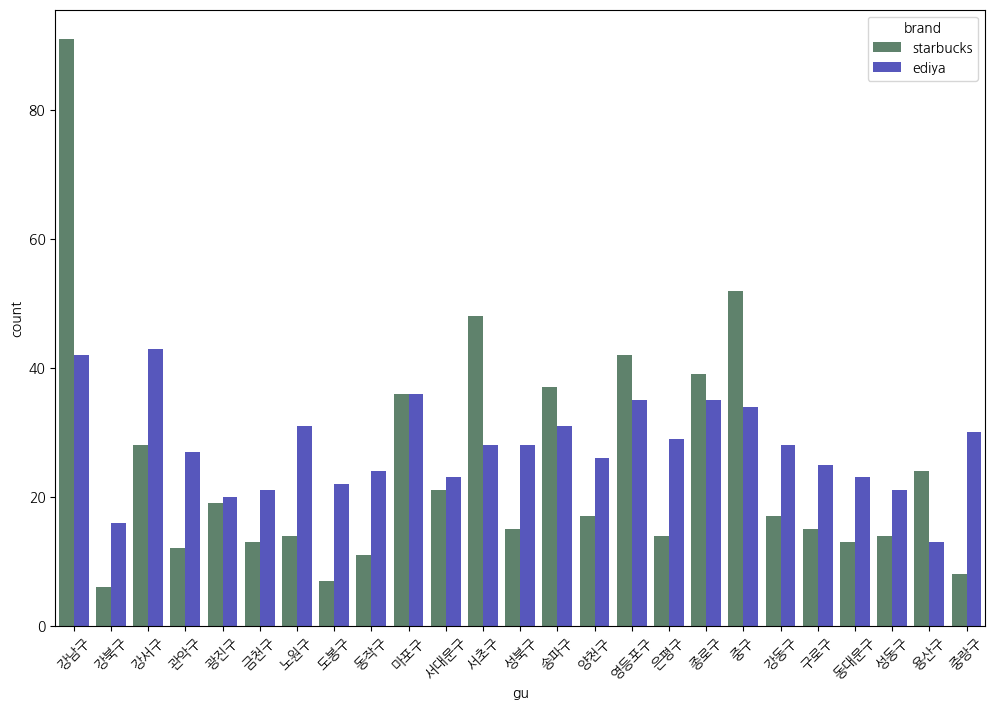

In [3]:
colors = ["#59886B", "#4646CD"]
sns.set_palette(sns.color_palette(colors))

plt.figure(figsize=(12, 8))
sns.barplot(x="gu", y="count", hue="brand", data=each_brand_count_df)
plt.xticks(rotation=45)
plt.show()

>> 스타벅스 매장은 강남구에 밀집되어 있고, 이디야 매장은 구 전체에 고르게 분포하는 양상을 보임.

2. folium으로 지도 시각화

In [4]:
local = mysql.connector.connect(
    host = "localhost",
    port = 3306,
    user = "root",
    password = "1",
    database = "amrbase"
)

cur = local.cursor(buffered=True)

sql = \
    """
    select latitude, longtitude
    from starbucks
    """
s_map_df = pd.read_sql(sql, con=local)

sql = \
    """
    select latitude, longtitude
    from ediya
    """
e_map_df = pd.read_sql(sql, con=local)

local.close()

display(s_map_df.head())
display(e_map_df.head())

/tmp/ipykernel_5267/3873676969.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  s_map_df = pd.read_sql(sql, con=local)
/tmp/ipykernel_5267/3873676969.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  e_map_df = pd.read_sql(sql, con=local)


,latitude,longtitude
0,37.5011,127.043
1,37.5102,127.022
2,37.5139,127.021
3,37.4995,127.031
4,37.4947,127.063


,latitude,longtitude
0,37.5059,127.026
1,37.5165,127.041
2,37.5141,127.028
3,37.5013,127.052
4,37.5223,127.031


In [5]:
geo_path = "../EDA/data/02. skorea_municipalities_geo_simple.json"
geo_str = json.load(open(geo_path, encoding="utf-8"))

tiles = "https://tiles.stadiamaps.com/tiles/stamen_toner/{z}/{x}/{y}{r}.png?api_key=c2cc2e93-c5d1-4f4c-9250-843d23b7da20"
attr = "toner"

my_map = folium.Map(location=(37.5502, 126.982), zoom_start=12, tiles=tiles, attr=attr)
setting = folium.Choropleth(geo_data=geo_str,
                            key_on="feature.id",
                            fill_color="lightyellow")
setting.add_to(my_map)

for idx, rows in s_map_df.iterrows():
    folium.CircleMarker(location=[rows["latitude"], rows["longtitude"]],
                  radius=5,
                  color="darkgreen",
                  fill_color="darkgreen").add_to(my_map)
    
for idx, rows in e_map_df.iterrows():
    folium.CircleMarker(location=[rows["latitude"], rows["longtitude"]],
                  radius=4,
                  color="middleblue",
                  fill_color="blue",
                  fill_opacity=50).add_to(my_map)

    
my_map

3. 위도 및 경도 좌표를 미터 거리로 변환 (거리 m)

In [6]:
local = mysql.connector.connect(
    host = "localhost",
    port = 3306,
    user = "root",
    password = "1",
    database = "amrbase"
)
cur = local.cursor(buffered=True)

# === starbucks location table ======================== #
sql = \
    """
    drop table 
    if exists s_locations
    """
cur.execute(sql)

sql = \
    """
    CREATE TABLE s_locations 
    (
        id INT AUTO_INCREMENT PRIMARY KEY,
        name VARCHAR(255),
        coordinates POINT
    )
    """
cur.execute(sql)

sql = \
    """
    insert into s_locations (name, coordinates) 
        SELECT store_name, point(longtitude, latitude) 
        from starbucks
    """
cur.execute(sql)

# === ediya location table ========================== #
sql = \
    """
    drop table 
    if exists e_locations
    """
cur.execute(sql)

sql = \
    """
    CREATE TABLE e_locations 
    (
        id INT AUTO_INCREMENT PRIMARY KEY,
        name VARCHAR(255),
        coordinates POINT
    )
    """
cur.execute(sql)

sql = \
    """
    insert into e_locations (name, coordinates) 
        SELECT store_name, point(longtitude, latitude) 
        from ediya
    """
cur.execute(sql)

local.commit()
local.close()

In [13]:
local = mysql.connector.connect(
    host = "localhost",
    port = 3306,
    user = "root",
    password = "1",
    database = "amrbase"
)
cur = local.cursor(buffered=True)

sql = \
    """
    drop table 
    if exists stores_distance
    """
cur.execute(sql)

sql = \
    """
    CREATE TABLE stores_distance 
    (
        s_id INT,
        e_id INT,
        distance_in_meters float
    )
    """
cur.execute(sql)
            
sql = \
    """
    insert into stores_distance (s_id, e_id, distance_in_meters)
    select *
    from (SELECT
            s_id,
            e_id,
            round(ST_Distance_Sphere(coordinates1, coordinates2), 3) AS distance_in_meters
          FROM (SELECT
                    l1.id AS s_id,
                    l2.id AS e_id,
                    l1.coordinates AS coordinates1,
                    l2.coordinates AS coordinates2
                FROM
                    s_locations l1,
                    e_locations l2) AS distances  
          ) stores_distance
    """
cur.execute(sql)

local.commit()
local.close()

In [14]:
local = mysql.connector.connect(
    host = "localhost",
    port = 3306,
    user = "root",
    password = "1",
    database = "amrbase"
)
cur = local.cursor(buffered=True)
            
sql = \
    """
    select s_id, count(e_id) 
    from stores_distance 
    where distance_in_meters<=500 
    group by s_id
    order by s_id
    """
ediya_from_starbucks_in_500 = pd.read_sql(sql, con=local)

sql = \
    """
    select e_id, count(s_id) 
    from stores_distance 
    where distance_in_meters<=500 
    group by e_id
    order by e_id
    """
starbucks_from_ediya_in_500 = pd.read_sql(sql, con=local)

local.close()

display(ediya_from_starbucks_in_500.head())
display(starbucks_from_ediya_in_500.head())

/tmp/ipykernel_5267/73495876.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ediya_from_starbucks_in_500 = pd.read_sql(sql, con=local)
/tmp/ipykernel_5267/73495876.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  starbucks_from_ediya_in_500 = pd.read_sql(sql, con=local)


,s_id,count(e_id)
0,1,1
1,2,1
2,3,3
3,4,2
4,5,1


,e_id,count(s_id)
0,1,6
1,2,2
2,3,2
3,4,5
4,5,5


In [20]:
print(ediya_from_starbucks_in_500.mean()[1])
print(starbucks_from_ediya_in_500.mean()[1])

2.6137184115523464
2.9917355371900825


>> 스타벅스 각 매장에 대하여 500m 안에 존재하는 이디야 매장의 수의 평균은 2.6137184115523464  
>> 이디야 각 매장에 대하여 500m 안에 존재하는 스타벅스 매장의 수의 평균은 2.9917355371900825

In [7]:
from folium.plugins import HeatMap

my_map_1 = folium.Map(location=(37.5502, 126.982), zoom_start=12, tiles=tiles, attr=attr)
HeatMap(data=s_map_df[['latitude', 'longtitude']], radius=20).add_to(my_map_1)
print("서울시 starbucks 매장 위치 분포")
display(my_map_1)

my_map_2 = folium.Map(location=(37.5502, 126.982), zoom_start=12, tiles=tiles, attr=attr)
HeatMap(data=e_map_df[['latitude', 'longtitude']], radius=20).add_to(my_map_2)
print("서울시 ediya 매장 위치 분포")
display(my_map_2)

서울시 starbucks 매장 위치 분포


서울시 ediya 매장 위치 분포


- 브랜드별 매장 분포도 시각화

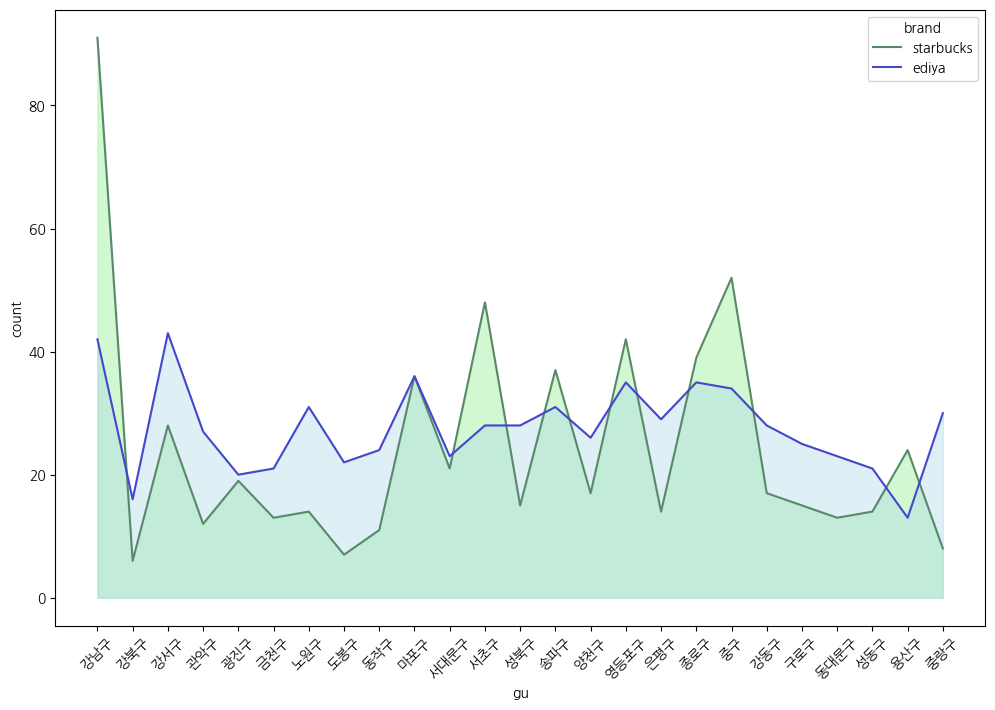

In [11]:
plt.figure(figsize=(12, 8))
sns.lineplot(x="gu", y="count", hue="brand", data=each_brand_count_df)
plt.xticks(rotation=45)

s = each_brand_count_df[each_brand_count_df['brand'] == "starbucks"]
plt.fill_between(s['gu'], s['count'], color="lightgreen", alpha=0.4)

e = each_brand_count_df[each_brand_count_df['brand'] == "ediya"]
plt.fill_between(e['gu'], e['count'], color="lightblue", alpha=0.4)

plt.show()

>> starbucks 매장은 서울 중심부, 특히 중구와 강남구에 집중적으로 분포되어 있다.   
>> 반면, ediya 매장은 서울 지역에 고르게 분포되어 있지만, starbucks 매장 분포와 마찬가지로, 중구와 강남구에 집중되어 있다.

/tmp/ipykernel_12410/3642150714.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter("longtitude", "latitude",
/tmp/ipykernel_12410/3642150714.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter("longtitude", "latitude",


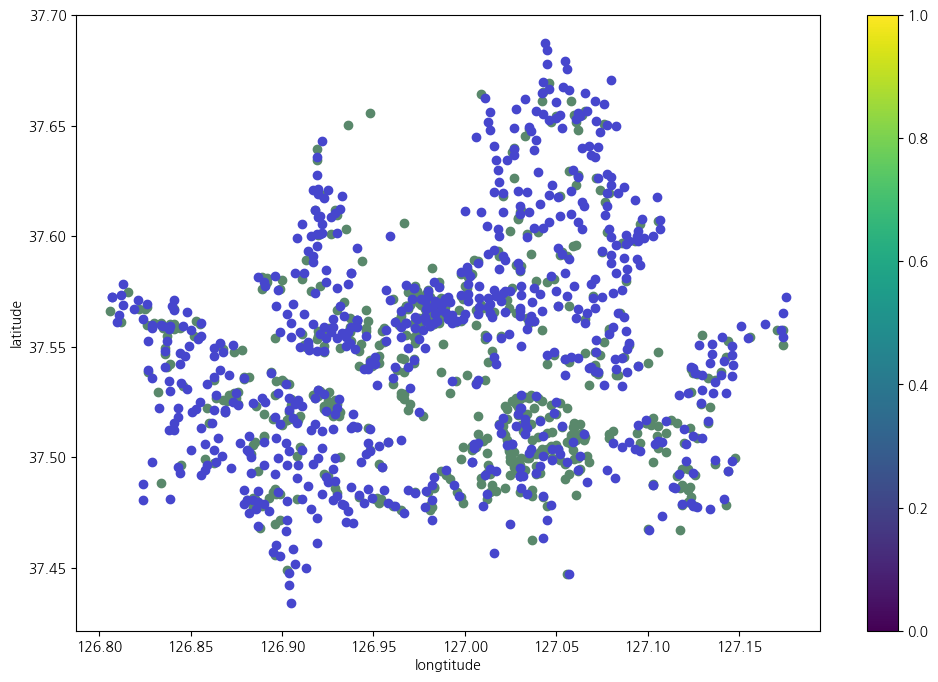

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter("longtitude", "latitude",
            data=s_map_df,
            cmap="green")
plt.scatter("longtitude", "latitude",
            data=e_map_df,
            cmap="blue")
plt.xlabel("longtitude")
plt.ylabel("latitude")
plt.colorbar()
plt.show()

/tmp/ipykernel_28361/704285821.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.displot(s_map_df, x="longtitude", y="latitude", palette="green")
/tmp/ipykernel_28361/704285821.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.displot(e_map_df, x="longtitude", y="latitude", palette="blue")


<Figure size 1200x800 with 0 Axes>

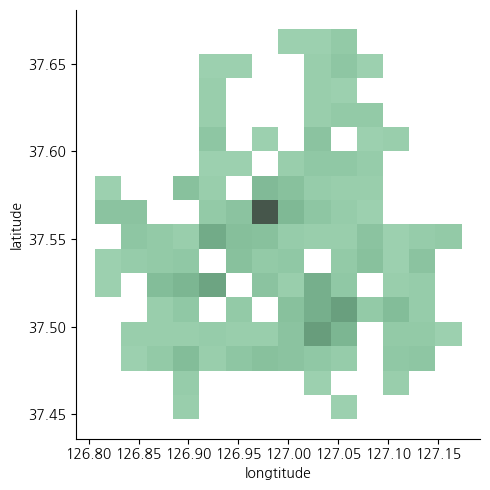

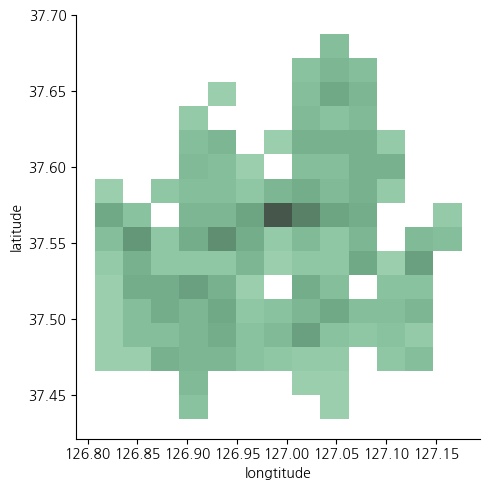

In [12]:
plt.figure(figsize=(12, 8))
sns.displot(s_map_df, x="longtitude", y="latitude", palette="green")
sns.displot(e_map_df, x="longtitude", y="latitude", palette="blue")
plt.show()

>> 시각화로 분석해본 결과,  
>> 서울시 스타벅스 매장과 이디야 매장의 분포가 다를 뿐더러  
>> 각 매장에 대한 500m 반경 안에 존재하는 상대 브랜드 매장 수의 평균도 스타벅스 보다 이디야가 더 크므로,  
>> '이디야는 스타벅스 매장이 위치시키는 곳에 위치시킨다.'라고 보기는 어렵다.